# Electromagnetics example

Author: Jørgen S. Dokken

Based on the tutorial by: Hans Petter Langtangen and Anders Logg

In this example, we will consider an iron cylinder with copper wires wound around the cylinder, as shown below

![Cross section of wires](wire.png)

Through the copper wires a static current of $J=1A$ is flowing.
We would like to compute the magnetic field $B$ in the iron cylinder, the copper wires, and the surrounding vaccum. 

We start by simplifying the problem to a 2D problem. We can do this by assuming that the cylinder extends far along the z-axis and as a consequence the field is virtually independent of the z-coordinate. 
Next, we consder Maxwell's equation to derive a Poisson equation for the magnetic field (or rather its potential)
$$
\nabla \cdot D = \rho,
$$
$$
\nabla \cdot B = 0,
$$
$$
\nabla \times E = -\frac{\partial B}{\partial t},
$$
$$
\nabla \times H = \frac{\partial D}{\partial t}+ J.
$$
Here, $D$ is the displacement field, $B$ is the magnetic field, $E$ is the electric field, and $H$ is the magnetizing field.
In addition to Maxwell's equation, we need a constitutive relation between $B$ and $H$,
$$
B =\mu H,
$$
which holds for an isotropic linear magnetic medium. 
Here, $\mu$ is the magnetic permability of the material. 
Now, since $B$ is solenodial (divergence free) accoording to Maxwell's equations, we known that $B$ must be the curl of some vector field $A$. This field is called the magnetic vector potential. Since the problem is static and thus $\frac{\partial D}{\partial t}=0$, it follows that
$$
J = \nabla \times H = \nabla \times(\mu^{-1} B)=\nabla \times (\mu^{-1}\nabla \times A ) = -\nabla \cdot (\mu^{-1}\nabla A).
$$
In the last step, we have expanded the second derivatives and used the gauge freedom of $A$ to simplify the equations to a simple vector-valued Poisson equation for the magnetic vector potential; if $B=\nabla \times A$, then $B=\nabla \times (A+\nabla \phi)$ for any scalar field $\phi$ (the gauge function).
For the current problem, we thus need to solve the following 2D Poisson problem for the $z$-component $A_z$ of the magnetic vector potential
$$
    - \nabla \cdot (\mu^{-1} \nabla A_z) = J_z \qquad \text{in } \mathbb{R}^2,\\
$$
$$
\lim_{\vert(x,y)\vert\to \infty}A_z = 0.
$$
Since we cannot solve the problem on an infinite domain, we will truncate the domain using a large disk, and set $A_z=0$ on the boundary. The current $J_z$ is set to $+1$A in the interior set of the circles (copper-wire cross sections) and to $-1$ A in the exteriror set of circles in the cross section figure.
Once the magnetic field vector potential has been computed, we can compute the magnetic field $B=B(x,y)$ by
$$
    B(x,y)=\left(\frac{\partial A_z}{\partial y}, - \frac{\partial A_z}{\partial x} \right).
$$
The weak formulation is easily obtained by multiplication of a test function $v$, followed by integration by parts, where all boundary integrals vanishes due to the Dirichlet condition, we obtain $a(A_z,v)=L(v)$ with
$$
a(A_z, v)=\int_\Omega \mu^{-1}\nabla A_z \cdot \nabla v ~\mathrm{d}x,
$$
$$
L(v)=\int_\Omega J_z v~\mathrm{d} x.
$$



## Meshing a complex structure with subdomains
Author: Jørgen S. Dokken

We create the domain visualized in the cross section figure above using gmsh. Note that we are using the `gmsh.model.occ.fragment` commands to ensure that the boundaries of the wires are resolved in the mesh.

In [1]:
import gmsh
import numpy as np
from mpi4py import MPI

rank = MPI.COMM_WORLD.rank

gmsh.initialize()
r = 0.1   # Radius of copper wires
R = 5     # Radius of domain
a = 1     # Radius of inner iron cylinder
b = 1.2   # Radius of outer iron cylinder
N = 8     # Number of windings
c_1 = 0.8 # Radius of inner copper wires
c_2 = 1.4 # Radius of outer copper wires
gdim = 2  # Geometric dimension of the mesh
if rank == 0:

    # Define geometry for iron cylinder
    outer_iron = gmsh.model.occ.addCircle(0, 0, 0, b)
    inner_iron = gmsh.model.occ.addCircle(0, 0, 0, a)
    gmsh.model.occ.addCurveLoop([outer_iron], 5)
    gmsh.model.occ.addCurveLoop([inner_iron], 6)
    iron = gmsh.model.occ.addPlaneSurface([5, 6])
    gmsh.model.occ.synchronize()

    # Define geometry for background
    background = gmsh.model.occ.addDisk(0, 0, 0, R, R)
    gmsh.model.occ.synchronize()

    # Define the copper-wires inside iron cylinder
    angles_N = [i*2*np.pi/N for i in range(N)]
    wires_N = [(2, gmsh.model.occ.addDisk(c_1*np.cos(v), c_1*np.sin(v), 0, r, r)) for v in angles_N]

    # Define the copper-wires outside the iron cylinder
    angles_S = [(i+0.5)*2*np.pi/N for i in range(N)]
    wires_S = [(2, gmsh.model.occ.addDisk(c_2*np.cos(v), c_2*np.sin(v), 0, r, r)) for v in angles_S]
    gmsh.model.occ.synchronize()
    # Resolve all boundaries of the different wires in the background domain
    all_surfaces = [(2, iron)]
    all_surfaces.extend(wires_S)
    all_surfaces.extend(wires_N)
    whole_domain = gmsh.model.occ.fragment([(2, background)], all_surfaces)
    gmsh.model.occ.synchronize()
    # Create physical markers for the different wires.
    # We use the following markers:
    # - Vacuum: 0
    # - Iron cylinder: 1
    # - Inner copper wires: $[2,3,\dots,N+1]$
    # - Outer copper wires: $[N+2,\dots, 2\cdot N+1]
    inner_tag = 2
    outer_tag = 2 + N
    background_surfaces = []
    other_surfaces = []
    for domain in whole_domain[0]:
        com = gmsh.model.occ.getCenterOfMass(domain[0], domain[1])
        mass = gmsh.model.occ.getMass(domain[0], domain[1])
        # Identify iron circle by its mass
        if np.isclose(mass, np.pi*(b**2-a**2)):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=1)
            other_surfaces.append(domain)
        # Identify the background circle by its center of mass
        elif np.allclose(com, [0, 0, 0]):
            background_surfaces.append(domain[1])

        # Identify the inner circles by their center of mass
        elif np.isclose(np.linalg.norm(com), c_1):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], inner_tag)
            inner_tag +=1
            other_surfaces.append(domain)
        # Identify the outer circles by their center of mass
        elif np.isclose(np.linalg.norm(com), c_2):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], outer_tag)
            outer_tag +=1
            other_surfaces.append(domain)
    # Add marker for the vacuum
    gmsh.model.addPhysicalGroup(2, background_surfaces, tag=0)
    # Create mesh resolution that is fine around the wires and
    # iron cylinder, coarser the further away you get
    gmsh.model.mesh.field.add("Distance", 1)
    edges = gmsh.model.getBoundary(other_surfaces)
    gmsh.model.mesh.field.setNumbers(1, "EdgesList", [e[1] for e in edges])
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "IField", 1)
    gmsh.model.mesh.field.setNumber(2, "LcMin", r / 2)
    gmsh.model.mesh.field.setNumber(2, "LcMax", 5 * r)
    gmsh.model.mesh.field.setNumber(2, "DistMin", 2 * r)
    gmsh.model.mesh.field.setNumber(2, "DistMax", 4 * r)
    gmsh.model.mesh.field.setAsBackgroundMesh(2)
    # Generate mesh
    gmsh.option.setNumber("Mesh.Algorithm", 7)
    gmsh.model.mesh.generate(gdim)    

As in [the Navier-Stokes tutorial](../chapter2/ns_code2) we load the mesh directly into dolfin-X, without writing it to file. This time, we create `MeshTags` for the physical cell data.

In [2]:
from dolfinx.io import extract_gmsh_geometry, extract_gmsh_topology_and_markers, ufl_mesh_from_gmsh
from dolfinx.cpp.io import perm_gmsh, extract_local_entities
from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.cpp.graph import AdjacencyList_int32
from dolfinx.mesh import create_meshtags, create_mesh
if rank == 0:
    # Get mesh geometry
    x = extract_gmsh_geometry(gmsh.model)

    # Get mesh topology for each element
    topologies = extract_gmsh_topology_and_markers(gmsh.model)
    # Get information about each cell type from the msh files
    num_cell_types = len(topologies.keys())
    cell_information = {}
    cell_dimensions = np.zeros(num_cell_types, dtype=np.int32)
    for i, element in enumerate(topologies.keys()):
        properties = gmsh.model.mesh.getElementProperties(element)
        name, dim, order, num_nodes, local_coords, _ = properties
        cell_information[i] = {"id": element, "dim": dim, "num_nodes": num_nodes}
        cell_dimensions[i] = dim

    # Sort elements by ascending dimension
    perm_sort = np.argsort(cell_dimensions)

    # Broadcast cell type data and geometric dimension
    cell_id = cell_information[perm_sort[-1]]["id"]
    tdim = cell_information[perm_sort[-1]]["dim"]
    num_nodes = cell_information[perm_sort[-1]]["num_nodes"]
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([cell_id, num_nodes], root=0)

    cells = topologies[cell_id]["topology"]
    cell_values = topologies[cell_id]["cell_data"]
else:
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
    cells, x = np.empty([0, num_nodes]), np.empty([0, gdim])
    cell_values = np.empty((0,))
gmsh.finalize()

  return array(obj, copy=False)



We now distribute the mesh over multiple processors

In [3]:
# Create distributed mesh
ufl_domain = ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = perm_gmsh(to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]
mesh = create_mesh(MPI.COMM_WORLD, cells, x[:, :gdim], ufl_domain)
tdim = mesh.topology.dim

local_entities, local_values = extract_local_entities(mesh, tdim, cells, cell_values)
mesh.topology.create_connectivity(tdim, 0)
adj = AdjacencyList_int32(local_entities)
ct = create_meshtags(mesh, tdim, adj, np.int32(local_values))

To inspect the mesh, we use Paraview, and obtain the following mesh

In [4]:
import dolfinx.io
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(ct)

We can also visualize the subdommains using pyvista

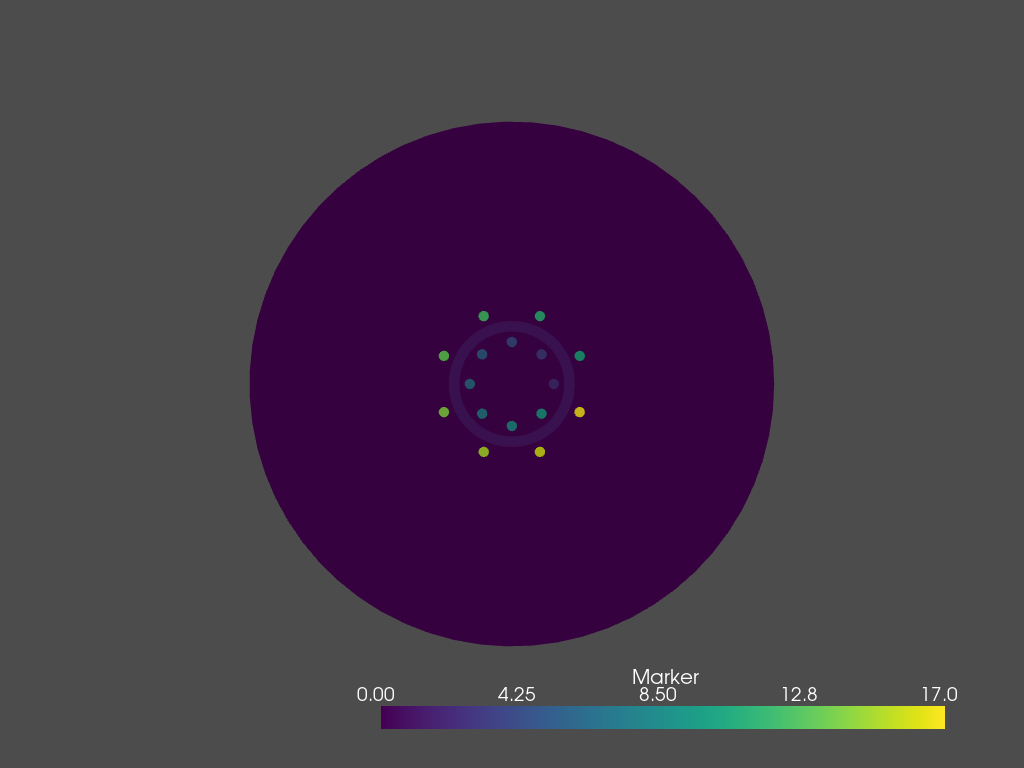

In [5]:
import pyvista
import dolfinx.plot
# Start virtual framebuffer
from pyvista.utilities.xvfb import start_xvfb
start_xvfb(wait=0)

plotter = pyvista.Plotter()
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local
grid.cell_arrays["Marker"] = ct.values[ct.indices<num_local_cells]
grid.set_active_scalars("Marker")
actor = plotter.add_mesh(grid)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
cell_tag_fig = plotter.screenshot("cell_tags.png")

Next, we define the discontinous functions for the permability $\mu$ and current $J_z$ using the `MeshTags` as in [Defining material parameters through subdomains](./subdomains)

In [6]:
Q = dolfinx.FunctionSpace(mesh, ("DG", 0))
material_tags = np.unique(ct.values)
mu = dolfinx.Function(Q)
J = dolfinx.Function(Q)
with mu.vector.localForm() as loc_mu, J.vector.localForm() as loc_J:
    # As we only set some values in J, initialize all as 0
    loc_J.set(0)
    for tag in material_tags:
        cells = ct.indices[ct.values==tag]
        num_cells = len(cells)
        # Set values for mu
        if tag == 0:
            mu_ = 4 * np.pi*1e-7 # Vacuum
        elif tag == 1:
            mu_ = 1e-5 # Iron (This should really be 6.3e-3)
        else:
            mu_ = 1.26e-6 # Copper
        loc_mu.setValues(cells, np.full(num_cells, mu_))
        # Set values for J
        if tag in range(2, 2+N):
            loc_J.setValues(cells, np.full(num_cells, 1))
        elif tag in range(2+N, 2*N + 2):
            loc_J.setValues(cells, np.full(num_cells, -1))

In the code above, we have used a somewhat less extreme value for the magnetic permability of iron. This is to make the solution a little more interesting. It would otherwise be completely dominated by the field in the iron cylinder.

We can now define the weak problem

In [7]:
import ufl
V = dolfinx.FunctionSpace(mesh, ("CG", 1))
u_bc = dolfinx.Function(V)
with u_bc.vector.localForm() as bc_loc:
    bc_loc.set(0)
facets = dolfinx.mesh.locate_entities_boundary(mesh, tdim-1, lambda x: np.full(x.shape[1], True))
dofs = dolfinx.fem.locate_dofs_topological(V, tdim-1, facets)
bc = dolfinx.DirichletBC(u_bc, dofs)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = (1 / mu) * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = J * v * ufl.dx

We are now ready to solve the linear problem

In [8]:
A_z = dolfinx.Function(V)
problem = dolfinx.fem.LinearProblem(a, L, u=A_z, bcs=[bc])
problem.solve()

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), FiniteElement('Lagrange', triangle, 1)), 7)

As we have computed the magnetic potential, we can now compute the magnetic field, by setting `B=curl(A_z)`. Note that as we have chosen a function space of first order piecewise linear function to describe our potential, the curl of a function in this space is a discontinous zeroth order function (a function of cell-wise constants). However, to simplify the visualization, we project the curl into a first order continous function space


In [9]:
W = dolfinx.VectorFunctionSpace(mesh, ("DG", 0))
p = ufl.TrialFunction(W)
q = ufl.TestFunction(W)
a_w = ufl.inner(p, q) * ufl.dx
L_w = ufl.inner(ufl.as_vector((A_z.dx(1), -A_z.dx(0))), q) * ufl.dx
projection = dolfinx.fem.LinearProblem(a_w, L_w)
B = projection.solve()

Note that we used `ufl.as_vector` to interpret the `Python`-tuple `(A_z.dx(1), -A_z.dx(0))` as a vector in the unified form language (UFL).

We now plot the magnetic potential $A_z$ and the magnetic field $B$. We start by creating a new plotter

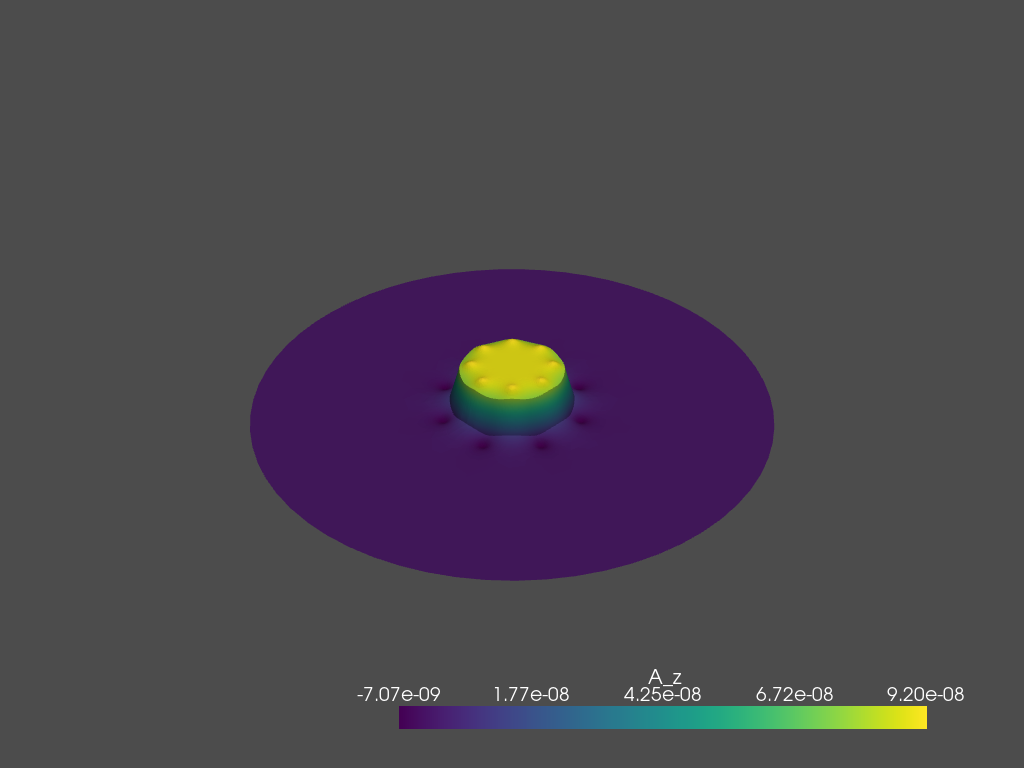

In [10]:
plotter = pyvista.Plotter()
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
num_dofs_local = V.dofmap.index_map.size_local
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
grid.point_arrays["A_z"] = A_z.compute_point_values()
grid.set_active_scalars("A_z")
warp = grid.warp_by_scalar("A_z", factor=1e7)
actor = plotter.add_mesh(warp)
if not pyvista.OFF_SCREEN:
    plotter.show()
Az_fig = plotter.screenshot("Az.png")

## Visualizing the magnetic field
As the magnetic field is a piecewise constant vector field, we need create a custom plotting function.
We start by computing the midpoints of each cell, which is where we would like to visualize the cell-wise constant vector.
Next, we take the data from the function `B`, and  shape it to become a 3D vector.
We connect the vector field with the midpoint by using `pyvista.PolyData`.

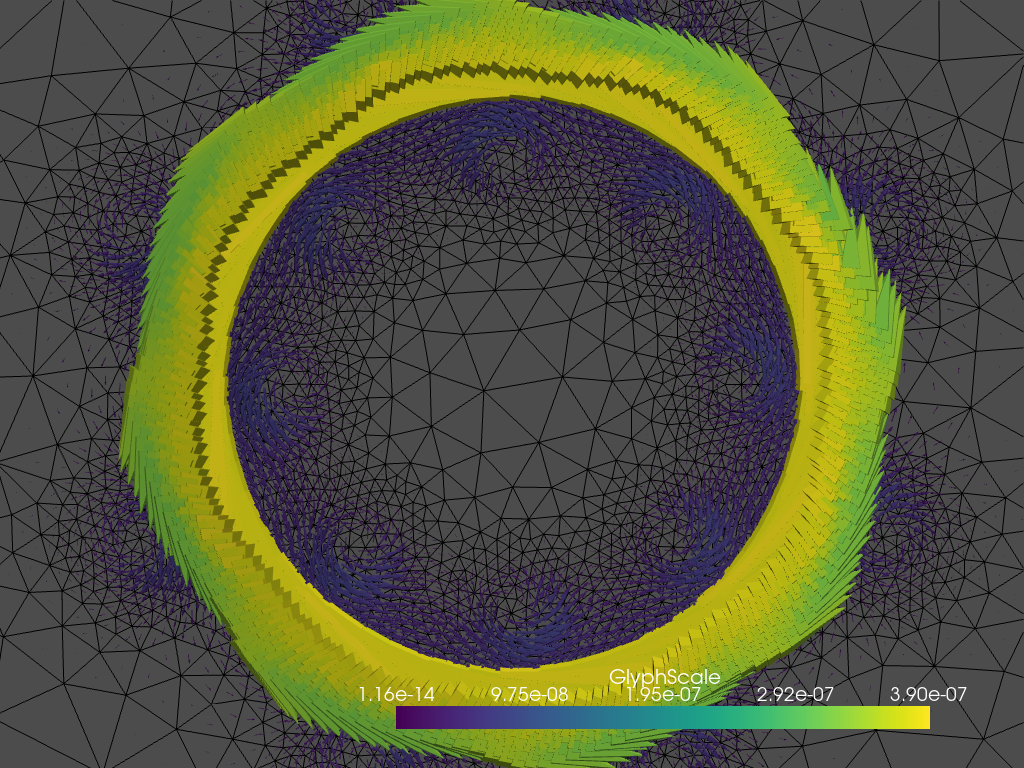

In [11]:
plotter = pyvista.Plotter()
plotter.set_position([0,0,5])

midpoints = dolfinx.cpp.mesh.midpoints(mesh, mesh.topology.dim, range(mesh.topology.index_map(mesh.topology.dim).size_local))

num_dofs_local = W.dofmap.index_map.size_local
values = np.zeros((num_dofs_local, 3), dtype=np.float64)
values[:, :mesh.geometry.dim] = B.vector.array.real.reshape(num_dofs_local, W.dofmap.index_map_bs)
cloud = pyvista.PolyData(midpoints)
cloud["B"] = values
glyphs = cloud.glyph("B", factor=2e6)
actor = plotter.add_mesh(grid, style="wireframe", color="k")
actor2 = plotter.add_mesh(glyphs)

if not pyvista.OFF_SCREEN:
    plotter.show()
B_fig = plotter.screenshot("B.png")